In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
!pip install tqdm
from tqdm import tqdm
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("processed_train.csv")

In [4]:
df.head()

,Unnamed: 0,ORIGIN_STAND,TAXI_ID,LEN,MON,DAY,HR,WK,ORIGIN_CALL_AVG_TIME,TAXI_ID_AVG_TIME,ORIGIN_STAND_AVG_TIME,WK_AVG_TIME,MON_AVG_TIME,HR_AVG_TIME,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,0,0.0,366,330,7,1,0,0,683.450173,673.103007,729.599652,721.988232,673.793106,596.947056,0,0,1
1,1,7.0,370,270,7,1,0,0,683.450173,693.969112,646.626119,721.988232,673.793106,596.947056,0,1,0
2,2,0.0,203,960,7,1,0,0,683.450173,671.735071,729.599652,721.988232,673.793106,596.947056,0,0,1
3,3,0.0,329,630,7,1,0,0,683.450173,623.547574,729.599652,721.988232,673.793106,596.947056,0,0,1
4,4,0.0,216,420,7,1,0,0,683.450173,709.728022,729.599652,721.988232,673.793106,596.947056,0,0,1


In [5]:
#Removing these for this MLP model only
df = df.drop(columns=["Unnamed: 0"])
#df = df.drop(columns=["Unnamed: 0", "TRIP_ID", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "TIMESTAMP"])
#df = df.drop(columns=["Unnamed: 0", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "TIMESTAMP", "YR_2014", "YR"])

In [6]:
df_sample = df#.sample(frac=0.5)

In [7]:
stand_size = len(df["ORIGIN_STAND"].unique())
taxi_size = len(df["TAXI_ID"].unique())
month_size = len(df["MON"].unique())
day_size = len(df["DAY"].unique())
hr_size = len(df["HR"].unique())
wk_size = len(df["WK"].unique())
#sizes = [stand_size, taxi_size, month_size, day_size, hr_size, wk_size]
sizes = [hr_size, wk_size]

In [8]:
df_len = df_sample["LEN"]
df_sample = df_sample.drop(columns=["LEN", "ORIGIN_STAND", "TAXI_ID", "MON", 'DAY'])

In [9]:
#Offset month and day by one because it originally starts at 1
#Helps with embedding later
#df_sample["MON"] = df_sample["MON"] - 1
#df_sample["DAY"] = df_sample["DAY"] - 1

In [10]:
len(df_sample)

1637710

In [11]:
#Normalize each columns
#df_sample = (df_sample-df_sample.min())/(df_sample.max()-df_sample.min())

In [12]:
df_sample.head()

,HR,WK,ORIGIN_CALL_AVG_TIME,TAXI_ID_AVG_TIME,ORIGIN_STAND_AVG_TIME,WK_AVG_TIME,MON_AVG_TIME,HR_AVG_TIME,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,0,0,683.450173,673.103007,729.599652,721.988232,673.793106,596.947056,0,0,1
1,0,0,683.450173,693.969112,646.626119,721.988232,673.793106,596.947056,0,1,0
2,0,0,683.450173,671.735071,729.599652,721.988232,673.793106,596.947056,0,0,1
3,0,0,683.450173,623.547574,729.599652,721.988232,673.793106,596.947056,0,0,1
4,0,0,683.450173,709.728022,729.599652,721.988232,673.793106,596.947056,0,0,1


In [13]:
features = df_sample.values

In [14]:
input_size = len(sizes) * (10 - 1) + len(features[0])
input_size

29

In [15]:
features[0]

array([  0.        ,   0.        , 683.45017324, 673.10300704,
       729.59965174, 721.98823218, 673.7931059 , 596.94705623,
         0.        ,   0.        ,   1.        ])

In [16]:
x = torch.tensor(np.array(features), dtype = torch.float).to(device)

y = torch.tensor(np.array(df_len.values), dtype = torch.float).to(device)

data = list(zip(x, y))
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data, test_data, val_data = torch.utils.data.random_split(data, [train_size, test_size, val_size])

In [17]:
batch_size = 3
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = False)
# train_loader = train_data
# valid_loader = val_data
# test_loader = test_data

In [18]:
len(train_data), len(test_data), len(val_data)

(1310168, 163771, 163771)

In [19]:
learning_rate = 1e-5

In [20]:
# model = torch.nn.Sequential(
#     torch.nn.Linear(input_size, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
#     torch.nn.ReLU(),
# #     torch.nn.Linear(1024, 1024),
#     #torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1),
# ).to(device)

In [21]:
class MLP(nn.Module):
    def __init__(self, sizes, input_size, hidden_size):
        super(MLP, self).__init__()
        #Embed layers for categorical features
        self.sizes_len = len(sizes)
        self.embeddings = [nn.Embedding(size, 10) for size in sizes]
        self.is_embedding = True
        # This is our holy embedding layer - the topic of this post
#         self.embedding_stand = nn.Embedding(stand_size, 10)
#         self.embedding_taxi = nn.Embedding(taxi_size, 10)

        # FC layers
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        
    def forward(self, x):
        # Pass input through the embedding layers
        if self.is_embedding:
            embeds = []
            for i, embedding in enumerate(self.embeddings):
                x_temp = embedding(torch.LongTensor((x[:, i].to("cpu").to(torch.long))))
                embeds.append(x_temp)

    #         x0 = self.embedding_stand(torch.LongTensor((x[:, 0].to("cpu").to(torch.long))).to(device))
    #         x1 = self.embedding_taxi(torch.LongTensor((x[:, 1].to("cpu").to(torch.long))).to(device))
            embeds = torch.hstack(embeds)

            #Take out the first two columns, add the new embedded vectors 
            x = torch.cat([x[:, self.sizes_len:], embeds.to(device)], dim=1).to(device)
        
        #Fully connected  layers
        return self.layers(x)
model = MLP(sizes, input_size, 1024).to(device)

In [22]:
loss_fn = torch.nn.MSELoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adagrad(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
from tqdm import trange
def train_epoch(train_data, model, optimizer, loss_fn, batch_size):
    losses = []
    train_len = len(train_data)
    
    # get a batch of training data
    for x, y in tqdm(train_data):
        # make predictions for this batch
        y_pred = torch.squeeze(model(x))
        
        # Compute the RSME loss
        loss = torch.sqrt(loss_fn(y_pred, y))
        
        # Backpropagation
        # zero out the gradients so that it will not accumulate through each iteration
        optimizer.zero_grad()
        
        # Compute the gradents with the backward call (backprop)
        loss.backward()
        
        # Update weight using gradient descent 
        optimizer.step()
        
        losses.append(loss.item())

    return np.mean(losses)

def eval_epoch(valid_loader, model, loss_function):
    losses = []
    with torch.no_grad(): 
        for x, y in tqdm(valid_loader):
            # Compute prediction
            y_pred = torch.squeeze(model(x))
            
            loss = torch.sqrt(loss_fn(y_pred, y))
            losses.append(loss.item())
            
    return np.mean(losses)

train_losses = []
val_losses = []

In [24]:
total_epochs = 20
max_acc = 0
val_loss = 0
print(f"Training on {len(train_data)} data with batch size of {batch_size}!")
for epoch in range(total_epochs):
    
    model.train() # gradient tracking is on
    
    train_loss = train_epoch(train_loader, model, optimizer, loss_fn, batch_size)
    
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = eval_epoch(valid_loader, model, loss_fn)
    val_losses.append(val_loss)
    scheduler.step()
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:>0.4f}, Validation Loss {val_loss:>0.4f}\n")

Training on 1310168 data with batch size of 3!


100%|█████████▉| 54548/54591 [00:50<00:00, 1170.68it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 54591/54591 [00:50<00:00, 1076.82it/s]


Epoch: 1, Train Loss: 318.6557, Validation Loss 334.4520



100%|██████████| 54591/54591 [00:44<00:00, 1222.09it/s]


Epoch: 2, Train Loss: 316.4583, Validation Loss 314.7529



100%|██████████| 54591/54591 [00:44<00:00, 1227.43it/s]


Epoch: 3, Train Loss: 315.9189, Validation Loss 313.2189



100%|██████████| 54591/54591 [00:48<00:00, 1137.31it/s]


Epoch: 4, Train Loss: 315.5720, Validation Loss 318.8621



100%|██████████| 54591/54591 [00:44<00:00, 1230.56it/s]


Epoch: 5, Train Loss: 315.4001, Validation Loss 312.8920



100%|██████████| 54591/54591 [00:48<00:00, 1123.88it/s]


Epoch: 6, Train Loss: 315.2811, Validation Loss 313.7701



100%|██████████| 54591/54591 [00:40<00:00, 1336.75it/s]


Epoch: 7, Train Loss: 315.2597, Validation Loss 312.3756



100%|██████████| 54591/54591 [00:46<00:00, 1167.75it/s]


Epoch: 8, Train Loss: 311.7729, Validation Loss 313.2451



100%|██████████| 54591/54591 [00:41<00:00, 1330.78it/s]


Epoch: 9, Train Loss: 311.5323, Validation Loss 311.4853



100%|██████████| 54591/54591 [00:40<00:00, 1344.29it/s]


Epoch: 10, Train Loss: 311.6416, Validation Loss 311.4129



100%|██████████| 54591/54591 [00:44<00:00, 1217.71it/s]


Epoch: 11, Train Loss: 311.6086, Validation Loss 311.4899



100%|██████████| 54591/54591 [00:37<00:00, 1445.74it/s]


Epoch: 12, Train Loss: 311.4826, Validation Loss 311.5445



100%|██████████| 54591/54591 [00:37<00:00, 1449.78it/s]


Epoch: 13, Train Loss: 311.5492, Validation Loss 313.0759



100%|██████████| 54591/54591 [00:37<00:00, 1444.15it/s]


Epoch: 14, Train Loss: 311.5503, Validation Loss 311.9286



100%|██████████| 54591/54591 [00:37<00:00, 1450.35it/s]


Epoch: 15, Train Loss: 311.1174, Validation Loss 311.2407



100%|██████████| 54591/54591 [00:37<00:00, 1452.88it/s]


Epoch: 16, Train Loss: 311.0213, Validation Loss 311.2184



100%|██████████| 54591/54591 [00:37<00:00, 1437.57it/s]


Epoch: 17, Train Loss: 311.1632, Validation Loss 311.2128



100%|██████████| 54591/54591 [00:40<00:00, 1355.50it/s]


Epoch: 18, Train Loss: 311.1571, Validation Loss 311.2569



100%|██████████| 54591/54591 [00:47<00:00, 1143.78it/s]


Epoch: 19, Train Loss: 311.0362, Validation Loss 311.2206



100%|██████████| 54591/54591 [00:38<00:00, 1426.91it/s]

Epoch: 20, Train Loss: 311.1367, Validation Loss 311.2260



In [25]:
model.eval()
eval_epoch(test_loader, model, loss_fn)

100%|██████████| 54591/54591 [00:38<00:00, 1424.67it/s]


310.45585870865085

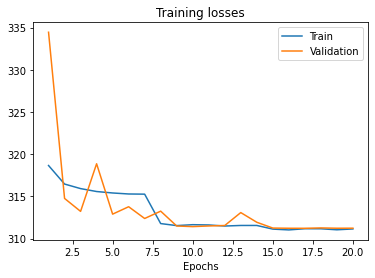

In [26]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
e = len(train_losses)
x_axis = np.arange(1, e + 1, 1)
plt.plot(x_axis, train_losses, label = "Train")
plt.plot(x_axis, val_losses, label = "Validation")
plt.legend()
plt.title('Training losses')
plt.xlabel("Epochs")
plt.show()

In [27]:
# count = 0
# loss_dict = {}
# with torch.no_grad(): 
#     for index, row in df_sample.iterrows():
#         x = torch.tensor(row.values, dtype=torch.float).to(device)
#         y_pred = model(x)

#         loss = torch.sqrt(loss_fn(y_pred, y[count]))
#         count += 1

#         loss_dict[index] = loss

In [28]:
# indexes = list(sorted(loss_dict))
# indexes[-11:-1]

In [29]:
df_orig = pd.read_csv("processed_train.csv")

In [30]:
torch.save(model, "MLP_embed_full_data")

In [31]:
#model = torch.load("MLP2.5")

In [32]:
df_test = pd.read_csv("processed_test.csv")
df_out = df_test["TRIP_ID"].to_frame()
#df_test = df_test.drop(columns=["Unnamed: 0", "TRIP_ID", "DAY_TYPE_A", "DAY_TYPE_B", "DAY_TYPE_C"])


In [33]:
#df_test["MON"] = df_test["MON"] - 1
#df_test["DAY"] = df_test["DAY"] - 1

In [34]:

df_test = df_test.drop(columns=["Unnamed: 0", "ORIGIN_STAND", "TAXI_ID", "MON", 'DAY', "TRIP_ID"])

In [35]:
df_test.head()

,HR,WK,ORIGIN_CALL_AVG_TIME,TAXI_ID_AVG_TIME,ORIGIN_STAND_AVG_TIME,WK_AVG_TIME,MON_AVG_TIME,HR_AVG_TIME,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,17,3,683.450173,702.514286,766.610383,710.283479,649.472439,822.471678,0,1,0
1,17,3,683.450173,680.091586,659.724281,710.283479,649.472439,822.471678,0,1,0
2,17,3,683.450173,622.094241,766.610383,710.283479,649.472439,822.471678,0,1,0
3,17,3,683.450173,623.333807,627.823529,710.283479,649.472439,822.471678,0,1,0
4,17,3,683.450173,624.266297,718.371884,710.283479,649.472439,822.471678,0,1,0


In [36]:
x_test = [torch.tensor(df_test.iloc[i].values,dtype=torch.float).to(device) for i in range(len(df_test))]

In [37]:
x_test = torch.utils.data.DataLoader(x_test)

In [38]:
model.eval()
with torch.no_grad(): 
    df_out["TRAVEL_TIME"] = [float(model(x).cpu()) for x in x_test]
df_out.head()

df_out.to_csv("my_pred.csv", index=None)

In [39]:
#TODO Implement accuracy or smthing for training
#Do something with validation (make a validation set)